# Demo: Defining WeatherForecast Workflows in Control-M using Python

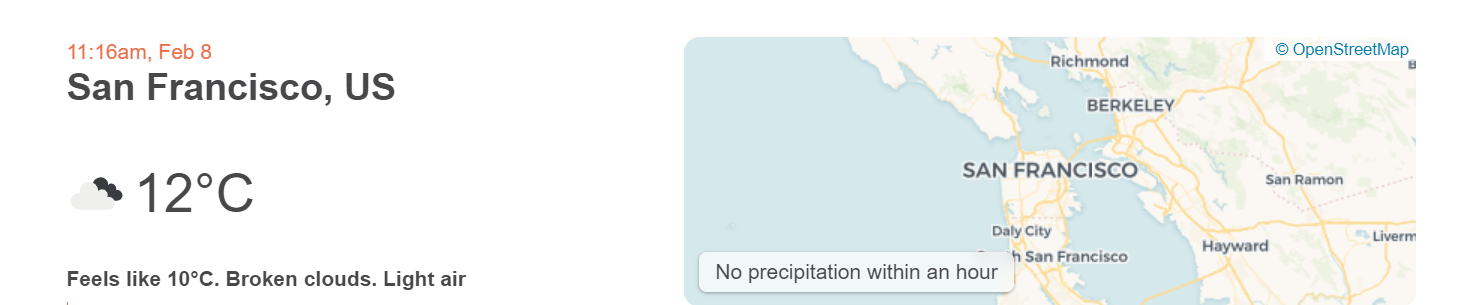

# Step 1 - Setup

## Step 1A - Install the library

In [1]:
#pip install ctm_python_client

In [2]:
!pip install git+https://github.com/tadinve/ctm_python_client.git

  Cloning https://github.com/tadinve/ctm_python_client.git to /tmp/pip-req-build-3wp03dly
  Running command git clone -q https://github.com/tadinve/ctm_python_client.git /tmp/pip-req-build-3wp03dly
  Resolved https://github.com/tadinve/ctm_python_client.git to commit 62acc49acf59bc9494cae016ee2a3df5d8ba6d35
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


## Step 1B- Import the library

In [3]:
from ctm_python_client.core.bmc_control_m import CmJobFlow
from ctm_python_client.jobs.dummy import DummyJob
from ctm_python_client.jobs.command import CommandJob 

# Step 2 - Instantiate, Authenticate and Schedule


## Step 2A - Create the object

In [4]:
import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/.secrets", "r") as fp:
    ctm_uri = fp.readline().strip()
    ctm_user = fp.readline().strip()
    ctm_pwd = fp.readline().strip()

In [5]:
# Please change the URfrI, and ctm_user and enter ctm_password to match your environment
from ctm_python_client.session.session import Session

session = Session( endpoint=ctm_uri,username=ctm_user,password=ctm_pwd)
session.get_token()

'B0AE4CF00F888AFD248C6B25D65856A1BB8BE9495EAA17500202A4F869F372AF5E4B3D757CFF9C60EF0732F0BE886F8D50CC17A36F26BB455E6665349BD78D1F'

In [6]:
t1_flow = CmJobFlow(application="Naga0.2_Demo",sub_application="Demo-02",session=session, ctm_uri=ctm_uri)

## Step 2B - Authenticate to Control-M

In [7]:
#t1_flow.ctm_login(ctm_uri, ctm_user, ctm_pwd, https=False)

## Step 2C - Define the Flow Level Defaults

### Default run_ass and host

In [8]:
t1_flow.set_run_as(username="ctmuser",host="acb-rhctmv20")

### Define Default Schedule

In [9]:
# Define the schedule
months = ["JAN", "OCT", "DEC"]
monthDays = ["ALL"]
weekDays = ["MON","TUE", "WED", "THU", "FRI"]
fromTime = "0300"
toTime = "2100"
t1_flow.set_schedule(months, monthDays, weekDays,fromTime, toTime)


# Step 3  - Folder

## Step 3A - Create Folder

In [10]:
# Create Folder
f1 = t1_flow.create_folder(name="WeatherForecast")

### Step 3B - Define Variables

In [11]:
#appid is the weather api token, you obtained during setup
variables = [ { "appid" : "481be8b9210a09cc3a3bcdcf190a3aa8"}, 
              { "zipcode" : "95130"}, 
              { "email" : "test@gmail.com"} ]
t1_flow.add_variables(folder=f1, list_of_variables=variables)

# Step 4 - Create Tasks

In [12]:
start = t1_flow.add_job(f1, DummyJob(folder= f1, job_name="StartFlow"))
end = t1_flow.add_job(f1, DummyJob(folder= f1, job_name="EndFlow"))


hostname = "acb-ubuntu.centralus.cloudapp.azure.com"
run_as="ctmuser"

#create job 1
j1 = CommandJob(folder=f1, job_name="GetMaxTemp", command="wget \"https://api.openweathermap.org/data/2.5/weather?zip=%%zipcode,us&appid=%%appid&units=imperial\" -O $HOME/output.json",
                              host=hostname, run_as=run_as)
GetMaxTemp =  t1_flow.add_job(folder=f1, job=j1)


#create job 2
j2 = CommandJob(folder=f1, job_name="CityVar", command="cd $HOME/ && city=$(cat output.json | jq -r \".name\") | echo \"$city\"",
                              host=hostname, run_as=run_as)
j2.capture_output( variable="city", capture_type="UpToEndOfLine", search_string="city=")
CityVar =  t1_flow.add_job(folder=f1, job=j2)

#create job 3
j3 = CommandJob(folder=f1, job_name="CountryVar", command="cd $HOME/ && country=$(cat output.json | jq -r \".sys.country\") | echo \"$country\"",
                              host=hostname, run_as=run_as)
j3.capture_output( variable="country", capture_type="UpToEndOfLine", search_string="country=")
CountryVar =  t1_flow.add_job(folder=f1, job=j3)

#create job 4
j4 = CommandJob(folder=f1, job_name="HighTempVar", command="cd $HOME/ && high_temp=$(cat output.json | jq \".main.temp_max\") | echo \"$high_temp\"",
                              host=hostname, run_as=run_as)
j4.capture_output( variable="hightemp", capture_type="UpToEndOfLine", search_string="high_temp=")
HighTempVar =  t1_flow.add_job(folder=f1, job=j4)

#create job 5
j5 = CommandJob(folder=f1, job_name="SendEmail", command="echo \\\"Today, the high temperature in %%city %%country is %%hightemp F.\\\"",
                              host=hostname, run_as=run_as)
j5.on_success_send_mail(mail_subject= "Today's High Temperature", mail_to="%%email", mail_message="Today, the high temperature in %%city %%country is %%hightemp F.")
SendEmail =  t1_flow.add_job(folder=f1, job=j5)




# Step 5 - Chain Tasks

In [13]:
t1_flow.chain_jobs(f1,[start, GetMaxTemp, HighTempVar, SendEmail, end])
t1_flow.chain_jobs(f1,[GetMaxTemp,CountryVar,SendEmail])
t1_flow.chain_jobs(f1,[GetMaxTemp,CityVar,SendEmail])


# Step 6 - Display Workflow

## Step 6A - Display DAG

=========== Jobflow Details ===================
Application:  Naga0.2_Demo
Sub Application:  Demo-02
Folder Name: WeatherForecast 



('StartFlow', 'GetMaxTemp', 'solid')
('GetMaxTemp', 'HighTempVar', 'solid')
('HighTempVar', 'SendEmail', 'solid')
('SendEmail', 'EndFlow', 'solid')
('GetMaxTemp', 'CountryVar', 'solid')
('CountryVar', 'SendEmail', 'solid')
('GetMaxTemp', 'CityVar', 'solid')
('CityVar', 'SendEmail', 'solid')


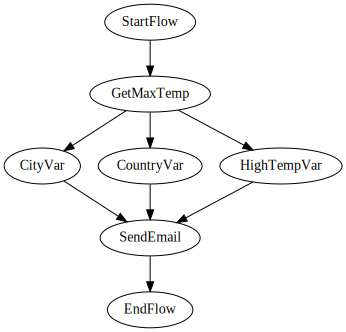

In [14]:
from ctm_python_client.utils.displayDAG import DisplayDAG

DisplayDAG(t1_flow).display_graphviz()

## Step 6B - Display JSON

In [15]:
t1_flow.display_json()

{
    "Defaults": {
        "Application": "Naga0.2_Demo",
        "SubApplication": "Demo-02",
        "RunAs": "ctmuser",
        "Host": "acb-rhctmv20",
        "When": {
            "Months": [
                "JAN",
                "OCT",
                "DEC"
            ],
            "MonthDays": [
                "ALL"
            ],
            "WeekDays": [
                "MON",
                "TUE",
                "WED",
                "THU",
                "FRI"
            ],
            "FromTime": "0300",
            "ToTime": "2100"
        }
    },
    "WeatherForecast": {
        "Type": "Folder",
        "Variables": [
            {
                "appid": "481be8b9210a09cc3a3bcdcf190a3aa8"
            },
            {
                "zipcode": "95130"
            },
            {
                "email": "test@gmail.com"
            }
        ],
        "StartFlow": {
            "Type": "Job:Dummy",
            "eventsToAdd": {
                "Type": "AddE

# Step 7 - Submit Workflow to Control-M

In [16]:
t1_flow.run()



Successfully Ran job on Control-M
	Application:  Naga0.2_Demo
	Sub Application:  Demo-02
	Folder Name:  WeatherForecast
Login to https://acb-rhctmv20.centralus.cloudapp.azure.com:8443/ControlM/ and use your workflow


{'monitor_page_uri': None,
 'run_id': 'cd7c362e-ccfa-4dee-8e2d-6e400fa6d52e',
 'status_uri': 'https://acb-rhctmv20.centralus.cloudapp.azure.com:8443/automation-api/run/status/cd7c362e-ccfa-4dee-8e2d-6e400fa6d52e'}

In [17]:
assert(1==1)